<h1>🚢 Ecommerce Customer & Product Analytics</h1>
<h4 style="color:#555; margin-top:-8px;">
Understanding sales drivers, seasonality, customer behavior and segment customers using K-Means </h4>

<hr style="border:1px solid #ddd;">

<div style="background-color:#fff9c4; padding:16px; border-radius:8px; border-left:5px solid #fbc02d;">

<h3>📘Executive Summary</h3>

This dataset contains transactional records from a UK-based online retailer (primarily selling all-occasion gifts) covering the period from December 1, 2010 to December 9, 2011. Note that it includes both sales and cancellations/returns (negative quantities).


</div>

<div style="background-color:pink; padding:16px; border-radius:8px; border-left:5px solid red;">
<h3>🎯 Key Questions: </h3>
<ul>
  <li>What are the revenue and order seasonality patterns?</li>
  <li>Which products/customers/countries drive revenue and volume?</li>
  <li>What does AOV distribution look like?</li>
  <li>Can we segment customers into meaningful groups?</li>
   <li> Is there any trend in cancellations? </li>
</ul> </div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3>  📂
    Dataset Overview </h3>
</div>

**File Used:** `data.csv`  
**Dataset Source:** Kaggle  
https://www.kaggle.com/datasets/carrie1/ecommerce-data

**Data Source**
* Ecommerce dataset (Kaggle)

**Raw Features** 
| Feature       | Description                                                                 |
|---------------|-----------------------------------------------------------------------------|
| `InvoiceNo`   | Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation |
| `StockCode`   | Product (item) code. A 5-digit integral number uniquely assigned to each distinct product |
| `Description` | Product (item) name / description                                          |
| `Quantity`    | The quantities of each product (item) per transaction (can be negative for cancellations/returns) |
| `InvoiceDate` | Date and time when each transaction was generated                          |
| `UnitPrice`   | Product price per unit in sterling (GBP)                                   |
| `CustomerID`  | Unique 5-digit customer identifier assigned to each customer               |
| `Country`     | Name of the country where the customer resides / where the order was shipped |


**Importing the Required Files**

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import squarify

In [2]:
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3> 🧹Data Cleaning & Preprocessing</h3>
</div>

In [7]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df_clean = df.copy() 
df_clean.columns = df_clean.columns.str.strip().str.lower()
df_clean['customerid'] = df_clean['customerid'].fillna("X")

In [9]:
df_clean.head(5)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
df_clean['customerid'] = pd.to_numeric(df_clean['customerid'], errors='coerce').astype('Int64')

In [11]:
df_clean['totalprice'] = df_clean['quantity'] * df_clean['unitprice']

In [12]:
df_clean['invoicedate'] = pd.to_datetime(df_clean['invoicedate'])

In [13]:
df_clean['year_month'] = df_clean['invoicedate'].dt.to_period('M').astype(str)
df_clean["year"] = df_clean['invoicedate'].dt.year
df_clean['month'] = df_clean['invoicedate'].dt.month
df_clean['month_name'] = df_clean['invoicedate'].dt.strftime("%b")


In [14]:
df_positive = df_clean[df_clean['totalprice'] > 0].copy()

In [15]:
df_returned = df_clean[df_clean['totalprice'] < 0].copy()

In [16]:
df_clean['is_cancelled'] = df_clean['invoiceno'].astype(str).str.startswith('C')

In [17]:
df_clean['is_cancelled'].unique()

array([False,  True])

In [85]:
df_cancelled = df_clean[df_clean['is_cancelled']]

<div style="background-color:#fff9c4; padding:16px; border-radius:8px; border-left:5px solid #fbc02d;">


<h4 style="margin-top:0;">Transaction Classification & Cancellation Handling Summary</h4>

<ul>

<li>Transactions were separated based on revenue direction:
    <ul>
        <li><b>df_positive</b> → Contains transactions with positive <code>totalprice</code> (valid sales).</li>
        <li><b>df_returned</b> → Contains transactions with negative <code>totalprice</code> (returns or refunds).</li>
    </ul>
</li>

<li>A boolean column <b><code>is_cancelled</code></b> was engineered by checking whether the <code>invoiceno</code> starts with the letter <b>'C'</b>, which indicates a cancelled transaction.</li>

<li>The <code>is_cancelled</code> column evaluates as:
    <ul>
        <li><b>True</b> → Cancelled invoice</li>
        <li><b>False</b> → Valid invoice</li>
    </ul>
</li>

<li>A separate dataframe <b><code>df_cancelled</code></b> was created to isolate cancelled transactions for independent analysis.</li>

<li>This preprocessing step ensures:
    <ul>
        <li>Accurate revenue calculations</li>
        <li>Clean customer behavior analysis</li>
        <li>Reliable segmentation and cohort results</li>
        <li>Prevention of inflated sales metrics</li>
    </ul>
</li>

</ul>
</div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3> Exploratory Data Analysis </h3>
</div>

#### 📊 KPI Snapshots ##

In [19]:
cancel_rate = df_clean['is_cancelled'].mean()

In [20]:
kpis = {
    "Total Revenue": f"${df_positive['totalprice'].sum():,.2f}",
    "Number of Transactions": df_positive['invoiceno'].nunique(),
    "Number of Unique Customers": df_positive['customerid'].nunique(),
    "Total Quantity Sold": f"{df_positive['quantity'].sum():,}",
    "Average Revenue per Transaction": f"${df_positive.groupby('invoiceno')['totalprice'].sum().mean():,.2f}",
    "Average Basket Size (units)": df_positive.groupby('invoiceno')['quantity'].sum().mean().round(1),
    "Overall Cancellation Rate": f"{cancel_rate:.2%}" 
}

for metric, value in kpis.items():
    print(f"{metric: <35} {value: >15}")

Total Revenue                        $10,666,684.54
Number of Transactions                        19960
Number of Unique Customers                     4338
Total Quantity Sold                       5,588,376
Average Revenue per Transaction             $534.40
Average Basket Size (units)                   280.0
Overall Cancellation Rate                     1.71%


#### Sales & Revenue Analysis ##

In [21]:
monthly_revenue = df_positive.groupby('year_month')['totalprice'].sum().reset_index(name='revenue')
monthly_revenue['revenue'] = pd.to_numeric(monthly_revenue['revenue'], errors='coerce')
monthly_revenue.dtypes

year_month     object
revenue       float64
dtype: object

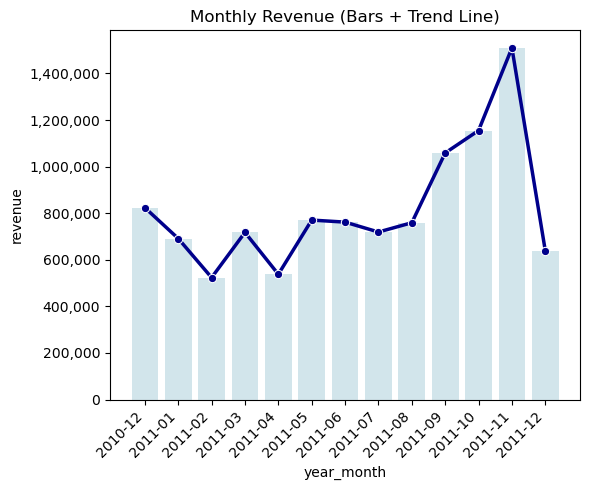

In [22]:
plt.figure(figsize=(6, 5))

ax = sns.barplot(data=monthly_revenue, x='year_month', y='revenue', color='lightblue', alpha=0.6)
sns.lineplot(data=monthly_revenue, x='year_month', y='revenue', color='darkblue', 
             marker='o', linewidth=2.5, ax=ax)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('Monthly Revenue (Bars + Trend Line)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #DFF6E3;">
<h4> Analysis: </h4> 
The chart shows a steady upward revenue trend throughout 2011, with moderate fluctuations in the first half of the year followed by strong acceleration in Q3 and Q4.

Revenue remains relatively stable between January and August, fluctuating between approximately 450K and 680K. Beginning in September, revenue increases sharply, peaking in November at around 1.15M — the highest month of the year.

December shows a noticeable decline compared to November, though revenue remains higher than early-year levels. Overall, the pattern demonstrates strong seasonality, with business performance heavily concentrated in the final quarter.

This suggests: Clear Q4 demand surge, Strong holiday-driven purchasing behavior, Progressive revenue growth leading into peak season
</div>

#### 📊 Revenue by Country (Bar Chart) ###

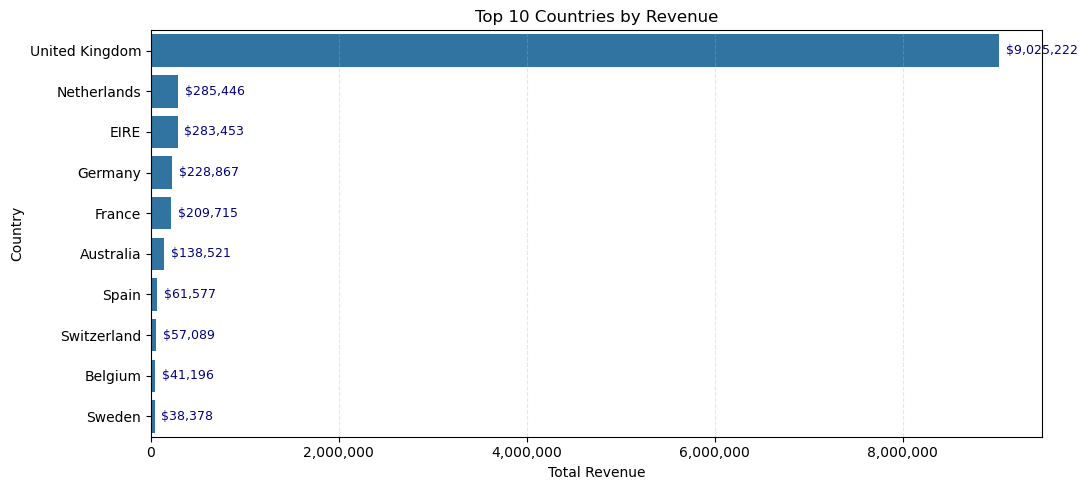

In [23]:
revenue_country = df_positive.groupby('country')['totalprice'].sum().reset_index(name='revenue')
revenue_country = revenue_country.sort_values('revenue', ascending=False)
plt.figure(figsize=(11,5))
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
ax = sns.barplot(data=revenue_country.head(10),x='revenue',y='country')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.bar_label(ax.containers[0],labels=[f'${int(v):,}' for v in ax.containers[0].datavalues],
    padding=5,fontsize=9,fontweight='medium',color='navy')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #DFF6E3;">
<h4> Analysis: </h4> 
The <strong>United Kingdom</strong> overwhelmingly dominates total revenue, generating approximately 
<strong>$7.3M</strong> — significantly higher than all other countries combined. This indicates that the business is highly concentrated in the UK market.

Among international markets, the <strong>Netherlands, EIRE, Germany, and France</strong> form the second tier, each contributing between 
<strong>$200K–$285K</strong>. All remaining countries contribute relatively small revenue shares, showing a steep drop-off after the top five markets.

This distribution suggests:
<ul>
<li>Strong domestic market dependency</li>
<li>Limited revenue diversification across international regions</li>
<li>Potential growth opportunities in underpenetrated countries</li>
</ul>
Overall, revenue is heavily skewed toward the UK, indicating geographic concentration risk while also demonstrating strong core-market dominance.
</div></div>

####  👥  Customer Analysis - Top Customers by Spend (Bar Chart)

In [24]:
customers_spent = ( df_positive.groupby('customerid', as_index=False).agg(total_spend=('totalprice', 'sum')).sort_values('total_spend', ascending=False).head(10))

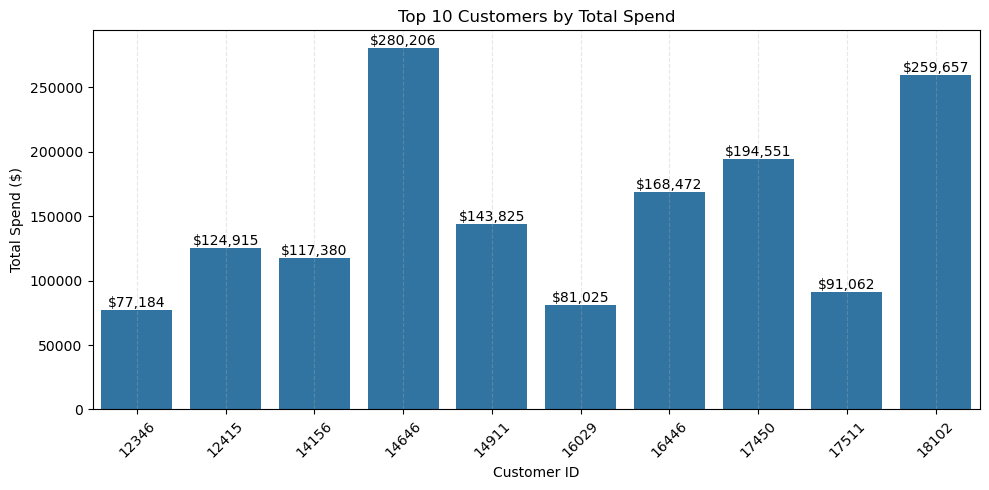

In [25]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=customers_spent,x='customerid',y='total_spend')
plt.title('Top 10 Customers by Total Spend')
plt.xlabel('Customer ID')
plt.ylabel('Total Spend ($)')
plt.xticks(rotation=45)  # rotate if IDs are long
ax.bar_label(ax.containers[0],fmt='${:,.0f}')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">

<h4 style="margin-top:0;">Analysis</h4>

The chart shows that revenue is concentrated among a small group of high-value customers. The top customer contributes approximately $280K, followed closely by another at $259K, while the remaining top customers range between $77K and $195K in total spend.

The noticeable gap between the highest spenders and the rest indicates revenue concentration within a limited segment of customers. This suggests strong value from top-tier customers but also potential dependency on a small group of major contributors.

Overall, a small number of customers drive a significant portion of total revenue, highlighting the importance of retention and relationship management strategies.
</div>

####  👥  Customer Cancellation Behavior Analysis

In [84]:
cancel_counts = df_clean['is_cancelled'].value_counts()

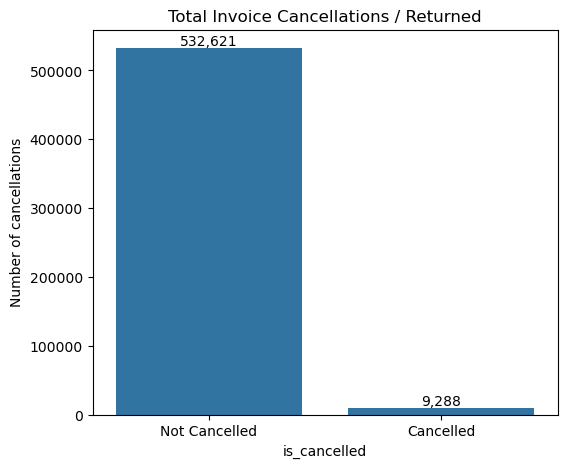

In [105]:
# Plot
plt.figure(figsize=(6,5))
ax = sns.barplot(x=cancel_counts.index,y=cancel_counts.values)
plt.xticks([0,1], ['Not Cancelled', 'Cancelled'])
plt.ylabel("Number of cancellations")
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
plt.title("Total Invoice Cancellations / Returned")
plt.show()

#### 🛒 Product Analysis

In [28]:
sales = df_positive.copy()
top_n = 10 

In [82]:
prod_rev = (
    sales.groupby(["stockcode", "description"], as_index=False).agg(revenue=("totalprice", "sum"),units=("quantity", "sum"),orders=("invoiceno", "nunique"))
         .sort_values("revenue", ascending=False)
)

In [30]:
top_prod = prod_rev.head(10).copy()

#### 🏷️ Top Products by Revenue (Bar Chart)

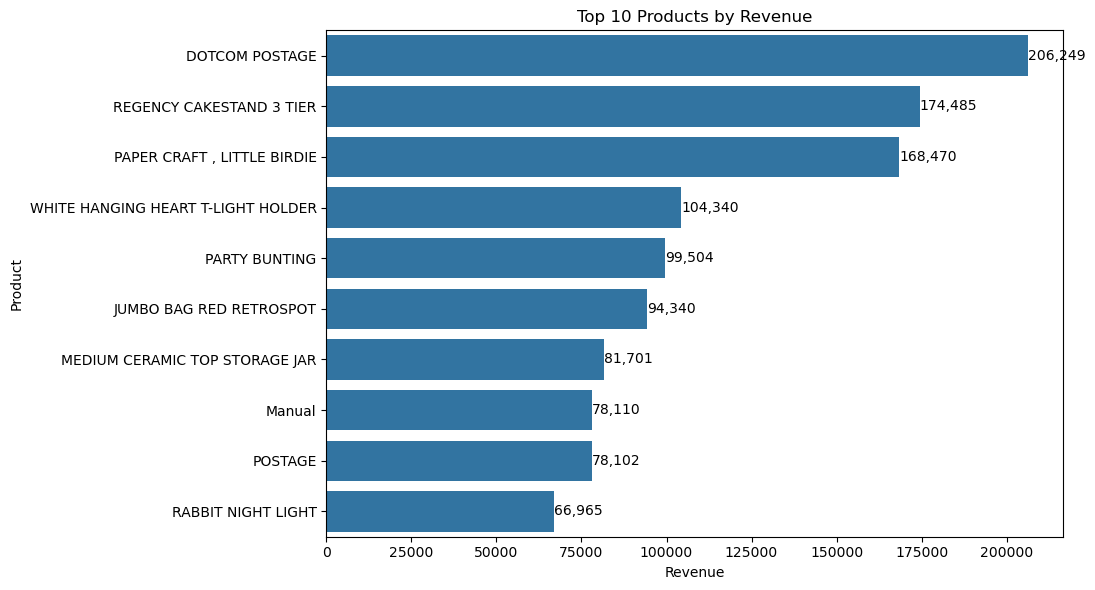

In [31]:
plt.figure(figsize=(11,6))
ax = sns.barplot(data=top_prod, y="description", x="revenue")
plt.title(f"Top {top_n} Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">

<h4 style="margin-top:0;">Analysis</h4>
<p>
The chart shows that revenue is concentrated among a small number of top-performing products. 
<strong>PAPER CRAFT, LITTLE BIRDIE</strong> leads significantly with approximately 
<strong>$168K</strong> in revenue, followed by 
<strong>REGENCY CAKE STAND 3 TIER</strong> at around <strong>$143K</strong>.
</p>

<p>
There is a noticeable drop after the top two products, with the remaining items generating 
between <strong>$51K and $100K</strong>.
</p>

<p>
This distribution indicates that a limited set of products drives a substantial share of total revenue. 
The gap between the highest-performing products and the rest suggests product-level concentration, 
highlighting the importance of inventory planning and continued promotion of best-selling items.
</p>

<p>
Overall, revenue performance appears skewed toward a few key products that contribute 
disproportionately to overall sales.
</p>

</div>

#### 📊 Most Frequently Purchased Items

In [32]:
top_units = prod_rev[['description', 'units']].sort_values('units',ascending=False).head(top_n)

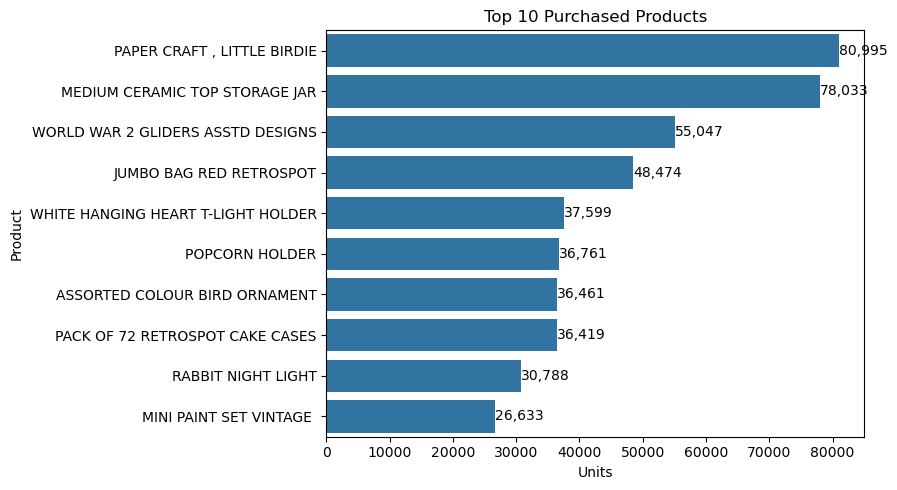

In [33]:
plt.figure(figsize=(9,5))
ax = sns.barplot(data=top_units, y="description", x="units")
plt.title(f"Top {top_n} Purchased Products")
plt.xlabel("Units")
plt.ylabel("Product")
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">
<h4 style="margin-top:0;">Analysis</h4><p>
The chart shows that PAPER CRAFT, LITTLE BIRDIE is the most frequently purchased product, with approximately 80,995 units sold, followed closely by MEDIUM CERAMIC TOP STORAGE JAR at around 77,916 units. There is a noticeable drop after the top two products, with the remaining items ranging between roughly 26K and 54K units.

This distribution indicates that a small group of products drives the highest purchase volume, reflecting strong customer demand for specific items. The variation between the top sellers and lower-ranked products suggests demand concentration within a limited product set.

Overall, purchasing behavior appears focused on a few high-volume products, emphasizing their importance in inventory management and supply planning.
    </div>

#### 📊 Total Cancellations by Product

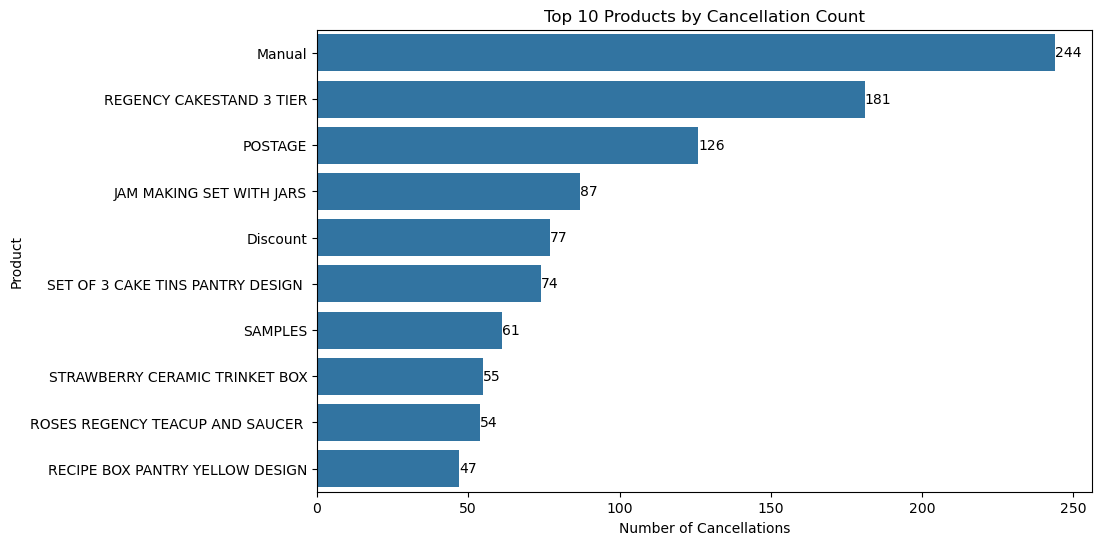

In [34]:
# Count cancellations by product
cancel_by_product = (df_cancelled.groupby('description').size().sort_values(ascending=False).head(10))
plt.figure(figsize=(10,6))
ax = sns.barplot(x=cancel_by_product.values,y=cancel_by_product.index)
ax.bar_label(ax.containers[0],fmt='{:,.0f}')
plt.title("Top 10 Products by Cancellation Count")
plt.xlabel("Number of Cancellations")
plt.ylabel("Product")
plt.show()

####  🌎 Geographic Analysis - Customers per Country (Bar Chart) ###

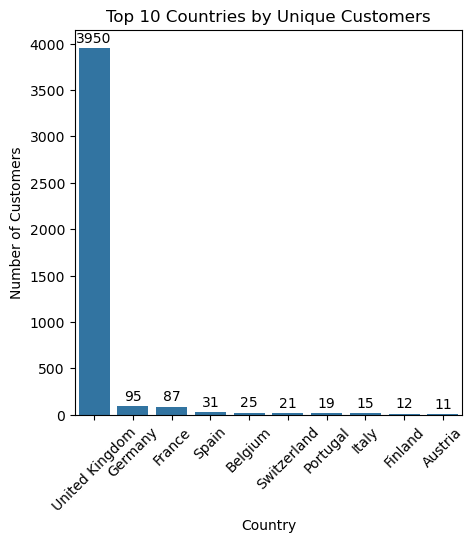

In [35]:
customers_per_country = (df_clean.groupby('country')['customerid'].nunique().sort_values(ascending=False).reset_index())
plt.figure(figsize=(5,5))
ax = sns.barplot(data=customers_per_country.head(10),x='country',y='customerid')
plt.title("Top 10 Countries by Unique Customers")
plt.xlabel("Country")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
for container in ax.containers:
    ax.bar_label(container, padding=2)
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">

<h4 style="margin-top:0;">Analysis</h4><p>
The chart shows that the United Kingdom overwhelmingly leads in the number of unique customers, with approximately 3,921 customers — significantly higher than all other countries. The next highest countries, Germany and France, have fewer than 100 customers each, indicating a substantial drop after the UK.

This distribution highlights strong customer concentration within the UK market, while international markets contribute relatively small customer bases. The sharp disparity suggests geographic dependence on a single dominant region.

Overall, customer acquisition appears heavily centered in the UK, with significant growth opportunities in underpenetrated international markets.
</div>

#### 🗺️ Revenue Concentration (UK vs Others)

In [36]:
other = customers_per_country[customers_per_country['country'] != 'United Kingdom']

In [37]:
df_clean['country_cat'] = np.where(df_clean['country'] == 'United Kingdom','UK','Other')

In [38]:
customers_per_country = (df_clean.groupby('country')['customerid'].nunique().sort_values(ascending=False).reset_index()).head(10)

In [208]:
customers_per_country['country_cat'] = np.where(customers_per_country['country'] == 'United Kingdom','UK','Other')
other_countries = [country for country in customers_per_country['country'].values if country!='United Kingdom']
other_countries

customers_per_country

,country,customerid,country_cat
0,United Kingdom,3950,UK
1,Germany,95,Other
2,France,87,Other
3,Spain,31,Other
4,Belgium,25,Other
5,Switzerland,21,Other
6,Portugal,19,Other
7,Italy,15,Other
8,Finland,12,Other
9,Austria,11,Other


In [217]:
uk_total = customers_per_country.loc[customers_per_country['country'] == 'United Kingdom','customerid'].sum()
other_total = customers_per_country.loc[customers_per_country['country'] != 'United Kingdom','customerid']

In [220]:
other_data = customers_per_country.loc[customers_per_country['country'] != 'United Kingdom']
other_data

,country,customerid,country_cat
1,Germany,95,Other
2,France,87,Other
3,Spain,31,Other
4,Belgium,25,Other
5,Switzerland,21,Other
6,Portugal,19,Other
7,Italy,15,Other
8,Finland,12,Other
9,Austria,11,Other


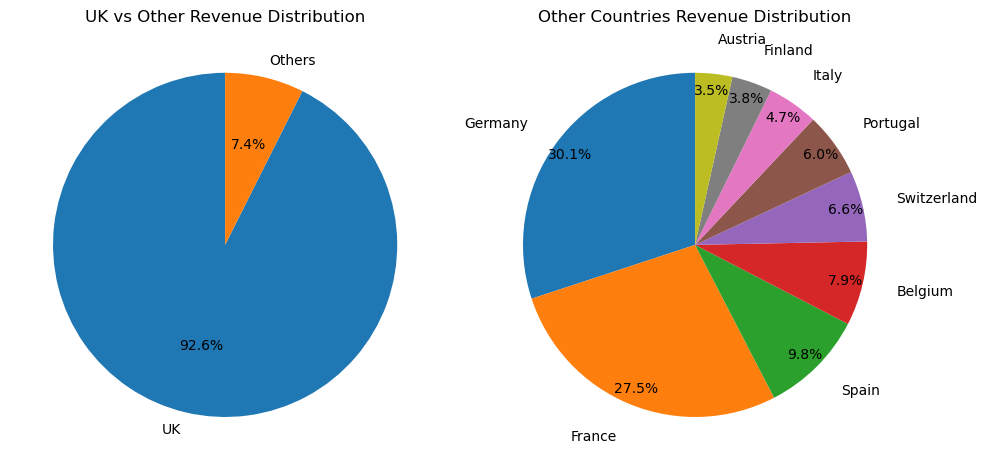

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pie([uk_total, other_total.sum()],labels=['UK', 'Others'],autopct='%1.1f%%',startangle=90,colors=['#1f77b4', '#ff7f0e'])
axes[0].set_title("UK vs Other Revenue Distribution")

axes[1].pie(other_total,labels=other_countries,autopct='%1.1f%%',startangle=90,pctdistance=0.90,  labeldistance=1.2)
axes[1].set_title("Other Countries Revenue Distribution")

plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">

<h4 style="margin-top:0;">Analysis</h4><p>
The chart shows that approximately 90.2% of customers are from the United Kingdom, while only 9.8% come from all other countries combined. This indicates a highly concentrated customer base within the UK market.

The overwhelming dominance of UK customers suggests strong domestic penetration but limited international reach. The relatively small share of customers from other countries highlights potential expansion opportunities in global markets.

Overall, the customer distribution reflects significant geographic concentration risk, with business performance heavily dependent on the UK market.
</div>

#### 🧮 Average Order Value Distribution

In [41]:
orders = (df_positive.groupby("invoiceno", as_index=False)
            .agg(order_value=("totalprice", "sum"),items=("quantity", "sum"),customer=("customerid", "first")))
orders.head()
aov = orders['order_value'].mean()
median_aov = orders['order_value'].median()

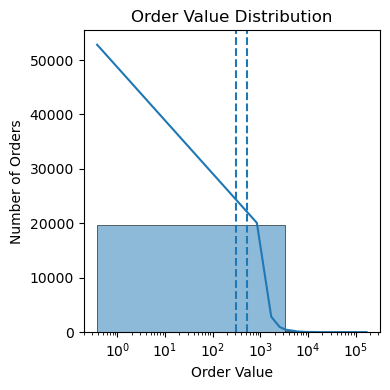

In [246]:
plt.figure(figsize=(4,4))
ax = sns.histplot(orders["order_value"], bins=50, kde=True)
ax.set_xscale("log")
plt.axvline(aov, linestyle='--', label=f'Mean: ${aov:,.0f}')
plt.axvline(median_aov, linestyle='--', label=f'Median: ${median_aov:,.0f}')
plt.title("Order Value Distribution")
plt.xlabel("Order Value")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">

<h4 style="margin-top:0;">Analysis</h4>
The distribution of order value is highly right-skewed, with the majority of orders concentrated at lower value ranges and a small number of extremely high-value outliers extending the tail.

Most orders fall within a relatively low spending bracket, while a limited number of large transactions significantly increase the maximum observed order value. This indicates that revenue is primarily driven by frequent smaller purchases, supplemented by occasional high-value bulk or wholesale orders.
Overall, the distribution suggests typical retail purchasing behavior with a small proportion of large orders influencing overall revenue metrics.
</div>

#### 📈 Seasonality Heatmap by Revenue

In [43]:
monthly = df_positive.groupby(['customerid', 'year_month']).agg(
    monthly_spent = ('totalprice', 'sum'),
    monthly_orders = ('invoiceno', 'nunique')
).reset_index()
monthly.head()

,customerid,year_month,monthly_spent,monthly_orders
0,12346,2011-01,77183.60,1
1,12347,2010-12,711.79,1
2,12347,2011-01,475.39,1
3,12347,2011-04,636.25,1
4,12347,2011-06,382.52,1


In [81]:
seasonality = (df_positive.groupby(['year', 'month_name'], as_index=False).agg(revenue=('totalprice', 'sum')))
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
seasonality['month_name'] = pd.Categorical(seasonality['month_name'],categories=month_order,ordered=True)
seasonality = seasonality.sort_values(['year', 'month_name'])
heatmap_data = seasonality.pivot(index='year',columns='month_name',values='revenue')

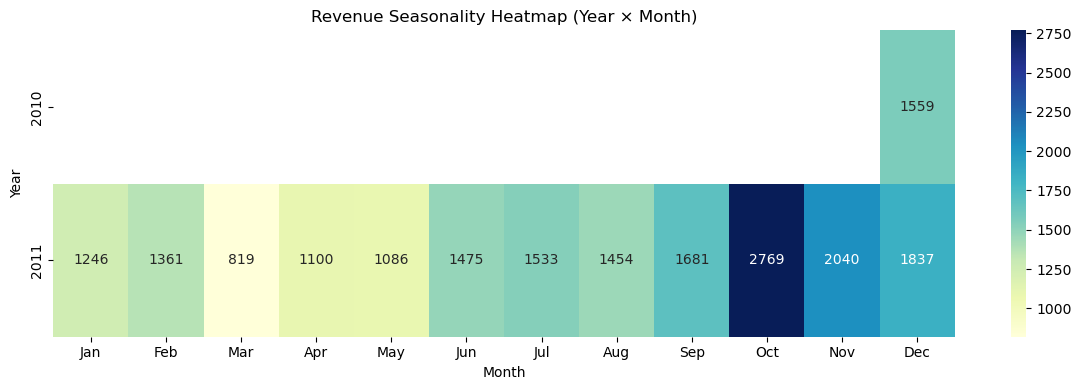

In [80]:
plt.figure(figsize=(12,4))
sns.heatmap(heatmap_data,annot=True,fmt=".0f",cmap="YlGnBu")
plt.title("Revenue Seasonality Heatmap (Year × Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #DFF6E3;">
<h4>Summary: </h4> 
The revenue heatmap highlights clear seasonal purchasing patterns, with strong revenue acceleration in the second half of the year.

In 2011, revenue steadily increases from mid-year, peaking significantly in September, October, and reaching its highest level in November (669,051). This indicates a strong Q4 performance, likely driven by holiday demand and increased consumer purchasing activity.

Early months (February and April) show comparatively lower revenue levels, suggesting seasonal slowdowns following peak periods. The consistent upward trend from late summer through November demonstrates pronounced seasonal demand concentration in Q4.

Overall, revenue is heavily skewed toward the final quarter of the year, indicating that business performance is strongly influenced by seasonal buying cycles — a critical insight for inventory planning, marketing timing, and revenue forecasting.</div>

#### 📈 Seasonality Heatmap by Orders

In [46]:
order_seasonality = (df_positive.groupby(['year', 'month_name'], as_index=False)
             .agg(order_count=('invoiceno', 'nunique')))
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
order_seasonality['month_name'] = pd.Categorical(seasonality['month_name'],categories=month_order,ordered=True)
order_seasonality = order_seasonality.sort_values(['year', 'month_name'])
heatmap_data = order_seasonality.pivot(index='year',columns='month_name',values='order_count')

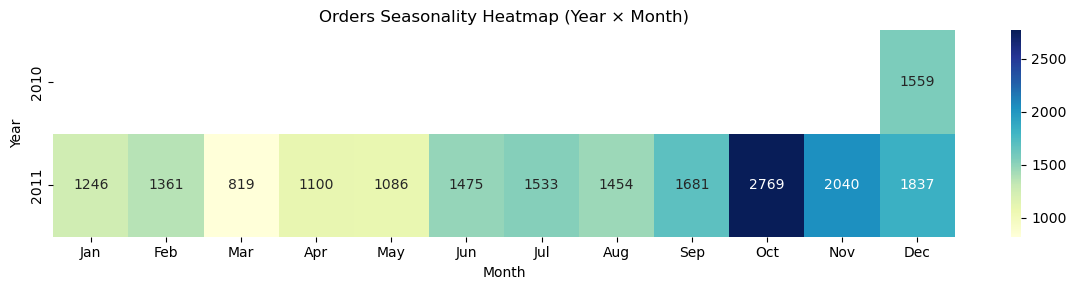

In [47]:
plt.figure(figsize=(12,3))
sns.heatmap(heatmap_data,annot=True,fmt=".0f",cmap="YlGnBu")
plt.title("Orders Seasonality Heatmap (Year × Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #DFF6E3;">
<h4>Summary: </h4> Order count represents the total number of unique invoices within a given time period. Since the dataset is at line-item level (one row per product per invoice), order count is calculated using the number of unique invoiceno values. This metric helps measure: overall transaction volume, seasonal demand patterns, business growth over time and customer purchasing activity. Unlike revenue, order count reflects purchasing frequency rather than order size, making it useful for identifying behavioral trends and demand cycles.
</div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3> Feature Engineering</h3>
</div>

In [74]:
df_cluster = df_positive.copy()

In [75]:
reference_date = df_cluster['invoicedate'].max() + pd.Timedelta(days=1)

In [76]:
rfm = df_cluster.groupby('customerid').agg({
    'invoicedate': lambda x: (reference_date - x.max()).days,  # Recency
    'invoiceno': 'nunique',                                   # Frequency
    'totalprice': 'sum'                                        # Monetary
}).reset_index()

In [77]:
rfm.head()

,customerid,invoicedate,invoiceno,totalprice
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3> Optimal Cluster Selection Using the Elbow Method</h3>
</div>

In [146]:
X = rfm.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['Recency', 'Frequency', 'Monetary']])

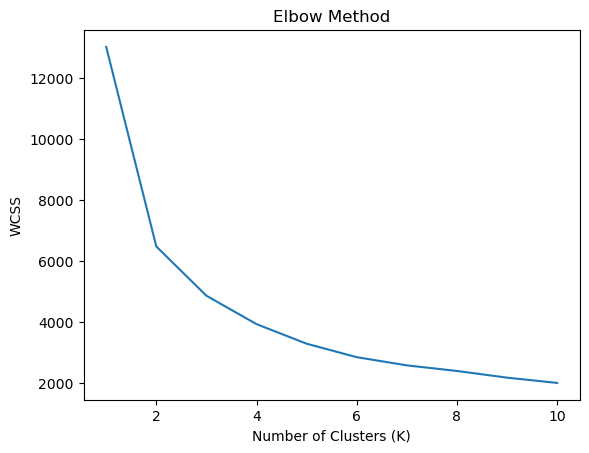

In [147]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">

<h4 style="margin-top:0;">Analysis</h4><p>
The Elbow Method was used to determine the optimal number of clusters for K-Means segmentation by analyzing the Within-Cluster Sum of Squares (WCSS). The curve shows a sharp decrease in WCSS from K=1 to K=3, followed by a more gradual decline beyond that point.

The noticeable bend (or “elbow”) around K = 3 suggests that three clusters provide a good balance between model simplicity and cluster separation. Adding more clusters beyond this point yields diminishing improvements in reducing WCSS.

Overall, the analysis indicates that three customer segments are appropriate for this dataset.</div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3> Optimal Cluster Selection Using the Silhoutte Model</h3>
</div>

In [148]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k={k}, Silhouette Score={score:.3f}")

k=2, Silhouette Score=0.433
k=3, Silhouette Score=0.337
k=4, Silhouette Score=0.337
k=5, Silhouette Score=0.316
k=6, Silhouette Score=0.313
k=7, Silhouette Score=0.310
k=8, Silhouette Score=0.301
k=9, Silhouette Score=0.282
k=10, Silhouette Score=0.279


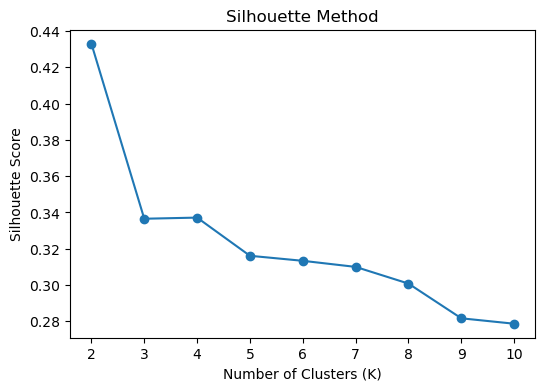

In [149]:
plt.figure(figsize=(6,4))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [150]:
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print("Best number of clusters:", best_k)

Best number of clusters: 2


<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">

<h4 style="margin-top:0;">Analysis</h4><p>
The Silhouette Method was used to evaluate cluster quality by measuring how well data points are separated across different values of K. The silhouette score is highest at K = 2, indicating the strongest cluster separation at this level.

As the number of clusters increases beyond 2, the silhouette score steadily declines, suggesting reduced cohesion and separation between clusters. This indicates that adding more clusters does not improve segmentation quality and may introduce overlap.

Overall, the analysis supports 2 clusters as the optimal segmentation for this dataset based on silhouette performance.</div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3> Applying K means </h3>
</div>

In [238]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [239]:
X['cluster'] = labels
X.head()

,customerid,Recency,Frequency,Monetary,cluster,customer_segment
0,12346,5.789960,0.693147,11.253955,1,VIP
1,12347,1.098612,2.079442,8.368925,1,VIP
2,12348,4.330733,1.609438,7.494564,1,VIP
3,12349,2.995732,0.693147,7.472245,0,Regular
4,12350,5.739793,0.693147,5.815324,0,Regular


In [240]:
X['customer_segment'] = X['cluster'].map({1: 'VIP',0: 'Regular'})

In [241]:
df_clustered = df_positive.merge(X[['customerid', 'customer_segment']],on='customerid',how='left')

In [242]:
X['customer_segment'].unique()

array(['VIP', 'Regular'], dtype=object)

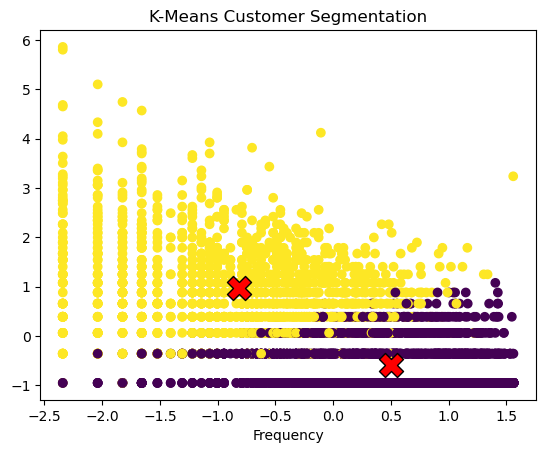

In [243]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=X['cluster'], cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=300, marker='X', label='Cluster Centers', edgecolor='black')
plt.xlabel("Frequency")
plt.ylabel("")
plt.title("K-Means Customer Segmentation")
plt.show()

In [244]:
segment_counts = X['customer_segment'].value_counts()
print(segment_counts)

customer_segment
Regular    2680
VIP        1658
Name: count, dtype: int64


In [245]:
X.groupby('customer_segment')[['Recency','Frequency','Monetary']].mean()

,Recency,Frequency,Monetary
customer_segment,,,
Regular,4.503341,0.935113,5.883885
VIP,2.743528,2.009067,7.740858


In [189]:
import pandas as pd

# Make sure you're using the correct dataframe
df_heat = df_clustered[['customerid', 'customer_segment', 'country']].drop_duplicates()
# Create pivot table
country_segment_pivot = (df_heat.groupby(['country', 'customer_segment'])['customerid'].nunique().unstack(fill_value=0).sort_values(by='Regular', ascending=False))
country_segment_pivot.head()

customer_segment,Regular,VIP
country,,
United Kingdom,2435,1485
Germany,49,45
France,45,42
Spain,18,12
Switzerland,14,7


In [198]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


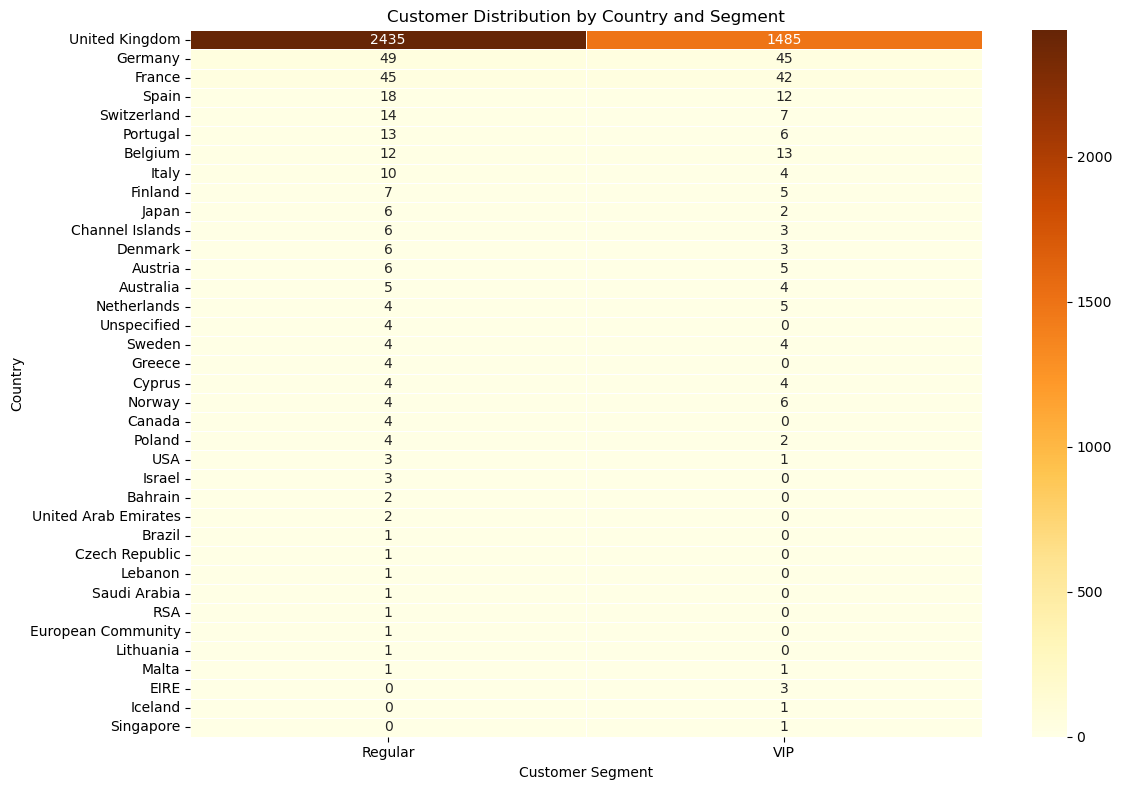

In [197]:
heatmap = country_segment_pivot
plt.figure(figsize=(12,8))
sns.heatmap(heatmap,annot=True,fmt="d",cmap="YlOrBr",linewidths=0.5)
plt.title("Customer Distribution by Country and Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

<div style="background-color:#E8F5E9; padding:16px; border-radius:8px; border-left:5px solid #2E7D32;">
<h4 style="margin-top:0;">Analysis</h4>
The heatmap highlights strong geographic concentration in the United Kingdom, with both Regular and VIP segments primarily UK-based. VIP customers, while fewer in number, show clear clustering within specific markets, indicating targeted high-value engagement patterns.

</div>
    </div>

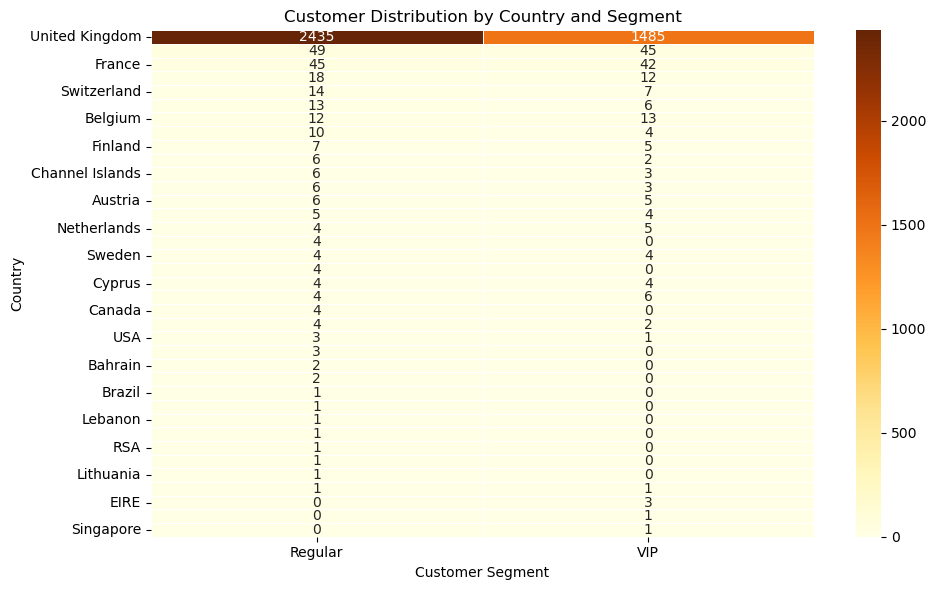

In [190]:
topn = country_segment_pivot
plt.figure(figsize=(10,6))
sns.heatmap(topn,annot=True,fmt="d",cmap="YlOrBr",linewidths=0.5)
plt.title("Customer Distribution by Country and Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3> Customer Segmentation – Final Analysis
</h3>
</div>

<div style="background-color:#F4F6F9; padding:16px; border-radius:8px; border-left:5px solid #F4F6F1;">
K-Means clustering was applied to customer-level purchasing behavior using frequency (number of orders) and monetary value (total spend). Based on model evaluation and cluster profiling, customers were segmented into two distinct groups.

The first segment,VIP Customers, demonstrates significantly higher purchase frequency and total spending. These customers contribute a disproportionate share of overall revenue and represent the core revenue-driving segment of the business.

The second segment, Regular Customers, exhibits lower transaction frequency and total spending. While individually contributing less revenue, this group represents a larger portion of the customer base and provides steady baseline sales.

The clustering results highlight revenue concentration among a smaller group of VIP customers, emphasizing the importance of retention strategies, targeted marketing, and loyalty programs for this segment. At the same time, there is opportunity to nurture Regular Customers through engagement initiatives aimed at increasing purchase frequency and spend.

Overall, the segmentation provides actionable insight into customer behavior and supports data-driven marketing and revenue optimization strategies.
    </div>